# Global Super Store Analysis

> The dataset is from: https://www.kaggle.com/datasets/apoorvaappz/global-super-store-dataset/data

### 1.Questons to be answered

- Customers Analysis
    - Profile the customers based on their frequency of purchase - calculate frequency of purchase for each customer
    - Do the high frequent customers are contributing more revenue
    - Are they also profitable - what is the profit margin across the buckets
    - Which customer segment is most profitable in each year.
    - How the customers are distributed across the countries
- Product Analysis
    - Which country has top sales?
    - Which are the top 5 profit-making product types on a yearly basis
    - How is the product price varying with sales - Is there any increase in sales with the decrease in price at a day level
    - What is the average delivery time across the counties - bar plot


### 2.Data Clean

In [ ]:
# import dataset and relevant libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('Global_Superstore2.csv', index_col='Row ID',  encoding = "ISO-8859-1")
df.head()

In [ ]:
# try to find the compliteness of the dataset
df.info()
df.describe()
# Based on the result, only 'Postal Code' has missing data where others are complete
# all the Dates columns are not in correct date type

In [ ]:
# change all the date columns to right date type
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d-%m-%Y')
df.head(5)

In [ ]:
# find duplicates
df.duplicated().sum()

In [ ]:
# Missing values only in Postal Codes which isn't critical
# Change the title Profit, Shipping Cost, Sales in USD Accordingly
# Rename index column to id

df.rename(columns={'Sales': '$Sales', 'Profit':'$Profit', 'Shipping Cost':'$Shipping Cost'}, inplace=True)
df.index.name = 'ID'
df.head()

In [ ]:
# save the cleaned dataset
df.to_csv('cleaned_global_superstore.csv', index=True)

### Data Analysis
#### 1. Customers Analysis

1.1 Profile the customers based on their frequency of purchase 
    - calculate frequency of purchase for each customer on a yearly basis

In [ ]:
# create a year column
df['Order Year'] = df['Order Date'].dt.year
df.head()
cust_grp = df.groupby(['Order Year', 'Customer ID', 'Customer Name'])
cust_df_frq = cust_grp.agg({'Quantity':'sum', 'Order ID':'count'})
# cust_df_frq = cust_grp.agg({'Quantity':'sum', 'Order ID':'count'}).reset_index()
cust_df_frq.rename(columns={'Quantity':'Total Quantity', 'Order ID': 'Total Orders'}, inplace=True)
total_order_count = cust_df_frq.groupby(level=0)['Total Orders'].transform('count') 
cust_df_frq['Frequency Rate %'] = (cust_df_frq['Total Orders'] / total_order_count) * 100
cust_df_frq = cust_df_frq.sort_values(by=['Order Year', 'Frequency Rate %'], ascending=[True, False])
# find top 10 buyers for each year
top_cust_buyer = cust_df_frq.groupby('Order Year').head(5)
top_cust_buyer

> Analysis:
> - For each year between 2011 and 2014, we selected top 5 most frequent buyers based on how many times they reorder. 
> - It shows that people are more addicted to shop again during the years.

In [ ]:
# create a year column
df['Order Year'] = df['Order Date'].dt.year

cust_grp = df.groupby(['Order Year', 'Customer ID', 'Customer Name'])

# find sum of quantity and sales by year
cust_agg = cust_grp.agg({'Quantity':'sum','$Sales': 'sum'}).sort_values(by=['Order Year', '$Sales', 'Quantity'], ascending=[True, False, False])

# find top 10 buyers for each year
top_cust_buyer = cust_agg.groupby('Order Year').head(5)
# Reset the DataFrame index for easier manipulation
df_reset = top_cust_buyer.reset_index()

# Sort by year and sales (descending)
df_sorted = df_reset.sort_values(['Order Year', '$Sales'], ascending=[True, False])

# Group by year and extract top 5 customers
grouped = df_sorted.groupby('Order Year').head(5)

# Prepare data
years = grouped['Order Year'].unique()
sales = grouped['$Sales'].values
customer_names = grouped['Customer Name'].values  # Use customer names for labels

# Generate x-axis positions for bars
x = np.arange(len(sales))

# Define a color palette for each year
colors = plt.cm.Set3.colors  # Use a predefined color map
year_colors = {year: colors[i] for i, year in enumerate(years)}

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Plot bars with year-specific colors
for i, (year, customer, sale) in enumerate(zip(grouped['Order Year'], customer_names, sales)):
    ax.bar(x[i], sale, color=year_colors[year], edgecolor='black', label=year if i % 5 == 0 else '')

# Customize x-axis labels for customer names
ax.set_xticks(x)
ax.set_xticklabels(customer_names, rotation=65, ha='center', fontsize=10)

# Labeling and styling
ax.set_ylabel('Sales ($)', fontsize=12)
ax.set_title('Top 5 Customers by Sales per Year', fontsize=20, pad=20)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on bars
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=8)

# Add legend for years
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(unique_labels.values(), unique_labels.keys(), title="Order Year", fontsize=10)

plt.tight_layout()
plt.show()


1.2 Do the high frequent customers are contributing more revenue

In [ ]:
# Here Sales are treated as revenue

# Need to find customers' Sales percentage against sum of all Sales
sales_grp = df.groupby(['Order Year', 'Customer ID', 'Customer Name']).agg({'$Sales':'sum'})
sales_grp
sales_grp['$Sales %'] = (sales_grp['$Sales'] / sales_grp.groupby(level=0)['$Sales'].transform('sum')) * 100
sales_grp['$Sales >= $Mean'] = sales_grp['$Sales'] >= sales_grp.groupby(level=0)['$Sales'].transform('mean')
# print(sales_grp)

# merge the data with previous step
result = pd.merge(cust_df_frq, sales_grp, on=['Order Year', 'Customer ID', 'Customer Name'])
top5 = result.sort_values(by=['Order Year', 'Frequency Rate %'], ascending=[True, False])
top5.groupby('Order Year').head(5)


> Analysis:
> - for each year, the top 5 most frequent buyers generate more sales than average, so it is clear that high frequent customers are contributing more revenue

1.3 Are they also profitable - what is the profit margin across the buckets

In [ ]:
# check the profit column
profit_grp = df.groupby(['Order Year', 'Customer ID', 'Customer Name']).agg({'$Profit':'sum'})

# merge profit_grp into result
result_new = pd.merge(result, profit_grp, on=['Order Year', 'Customer ID', 'Customer Name'])
result_new['Profit Margin %'] = result_new['$Profit'] / result_new['$Sales'] * 100
# check top 5 frequency buyers and their profit margin
result_new.groupby('Order Year').head()

> Analysis:
> - It's clearly that not all high frequency buyers are profitable

1.4 Which customer segment is most profitable in each year.

In [ ]:
# Agg profit by segment and year
seg_agg = df.groupby(['Order Year', 'Segment']).agg({'$Profit':'sum'})
seg_agg

> Analysis:
> - It's clearly that for each year, the 'Consumer' Segment contributes the most towards profitability.

1.5 How the customers are distributed across the countries


In [ ]:
# finding the customer by countries and by segments

# by countries
cust_df_country = df.groupby(['Country']).agg({'Customer ID':'count'})
cust_df_country.rename(columns={'Customer ID':'numCustomers'}, inplace=True)

# by countries and segments
cust_df_distr = df.groupby(['Country', 'Segment']).agg({'Customer ID':'count'})
cust_df_distr.rename(columns={'Customer ID':'numCustomers'}, inplace=True)

cust_df_country.sort_values(by='numCustomers', ascending=False, inplace=True)
cust_df_country.head()

> Analysis:
> - It's clear that US, Australia, France, Mexico and Germany are the top 5 countries by customer counts

#### 2. Product Analysis

2.1 Which country has top sales?

In [ ]:
# Find the sales group by countris

country_df = df.groupby('Country')['$Sales'].sum().reset_index()
country_df.sort_values(by='$Sales', ascending=False)

> Analysis:
> - It's clear that US has the top sales of 2.297201e+06 USD.

2.2 Which are the top 5 profit-making product types on a yearly basis?

In [ ]:
# Check data categories
df['Category'].value_counts()
df['Sub-Category'].value_counts()

# As there are only 3 Categories data so using Sub-Category
sub_cat_df = df.groupby(['Order Year', 'Sub-Category'])[['$Profit', '$Sales']].sum()
sub_cat_df['Profit Margin %'] = sub_cat_df['$Profit'] / sub_cat_df['$Sales'] * 100
sub_cat_df.sort_values(by=['Order Year', '$Profit'], ascending=[True, False], inplace=True)
sub_cat_df.groupby('Order Year').head()

> Analysis:
> - During the years: Copiers, Phones, Bookcases, Appliances, Accessories, Chairs are the most profitable items. For each year's data, please refer above.

2.3 How is the product price varying with sales - Is there any increase in sales with the decrease in price at a day level

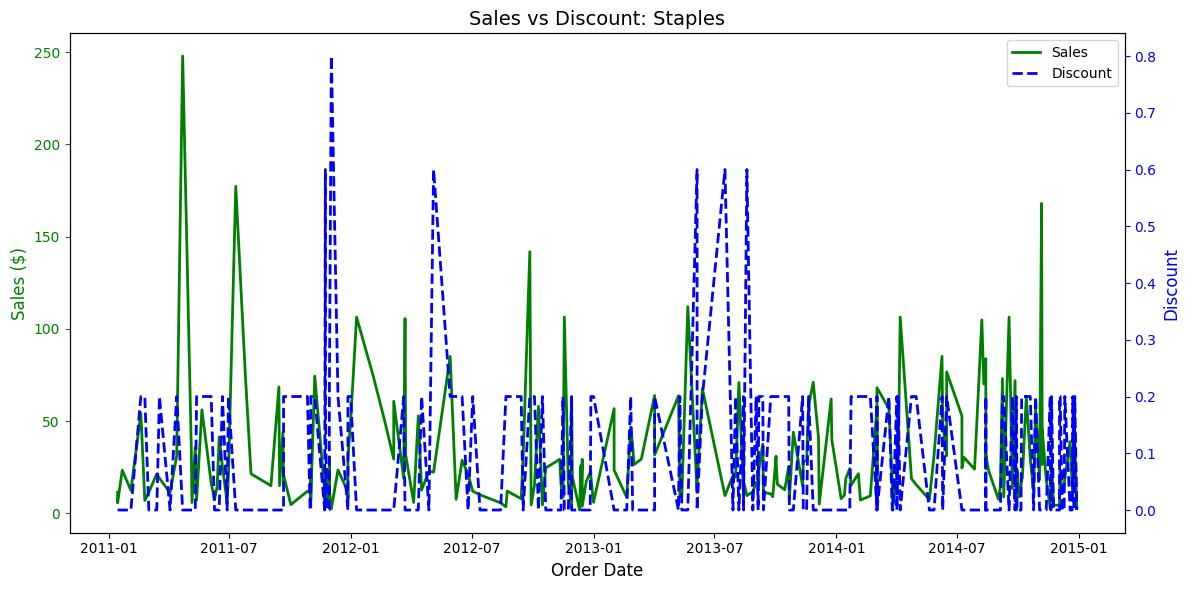

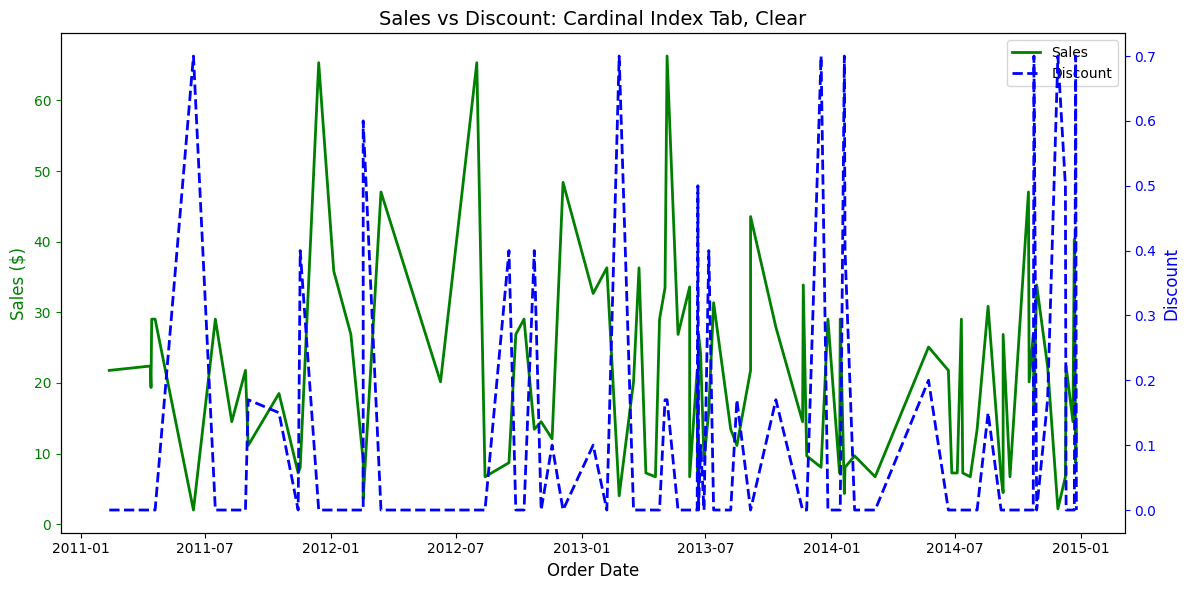

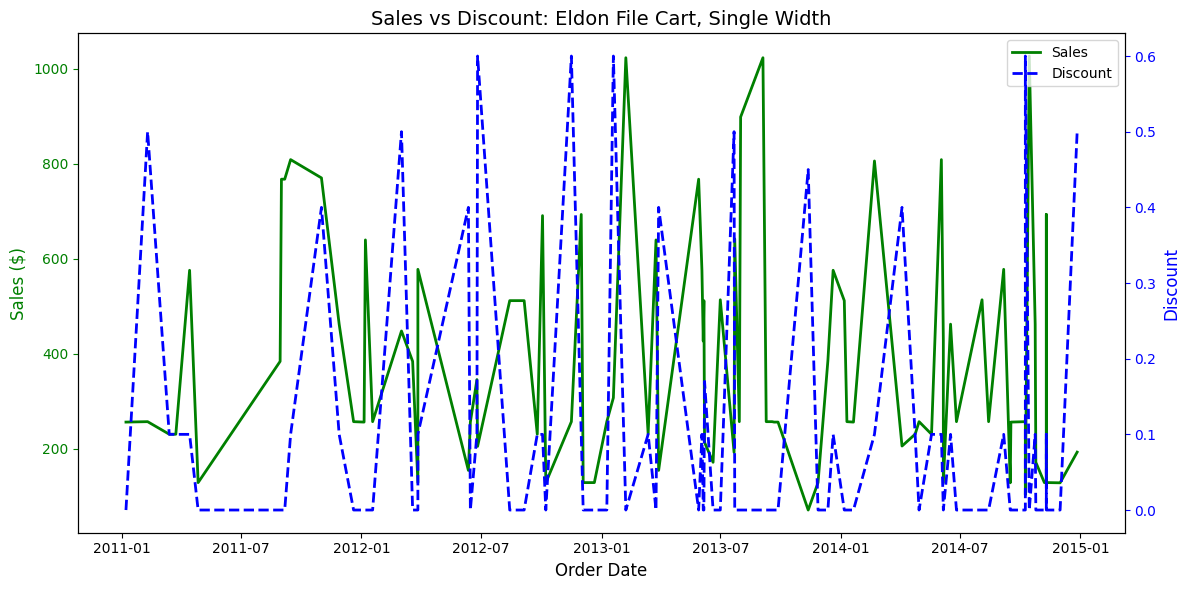

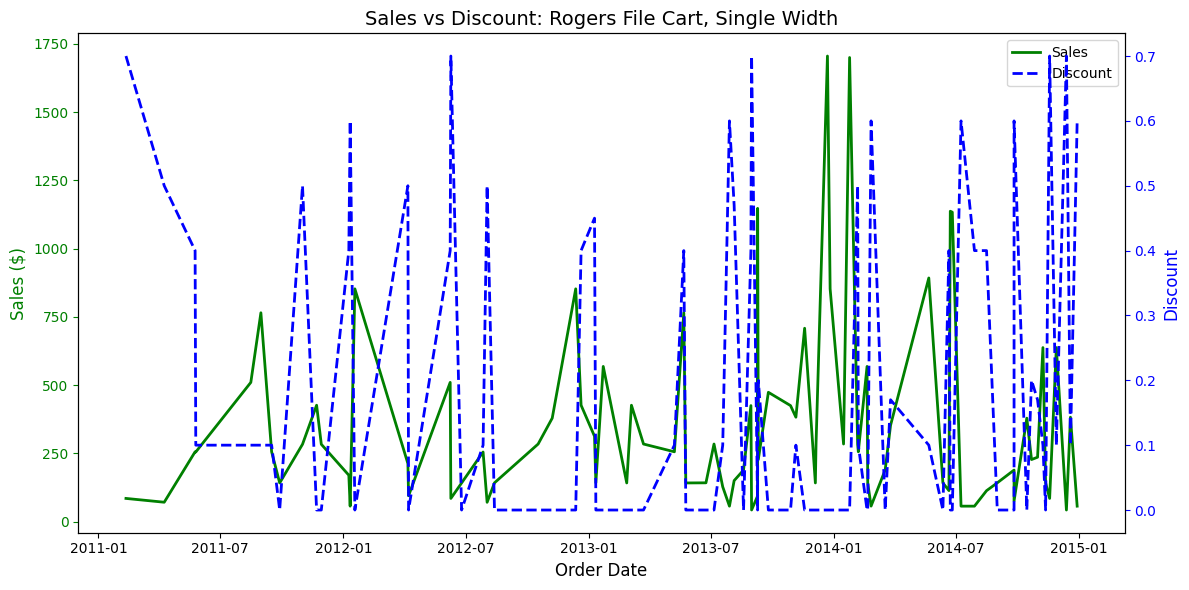

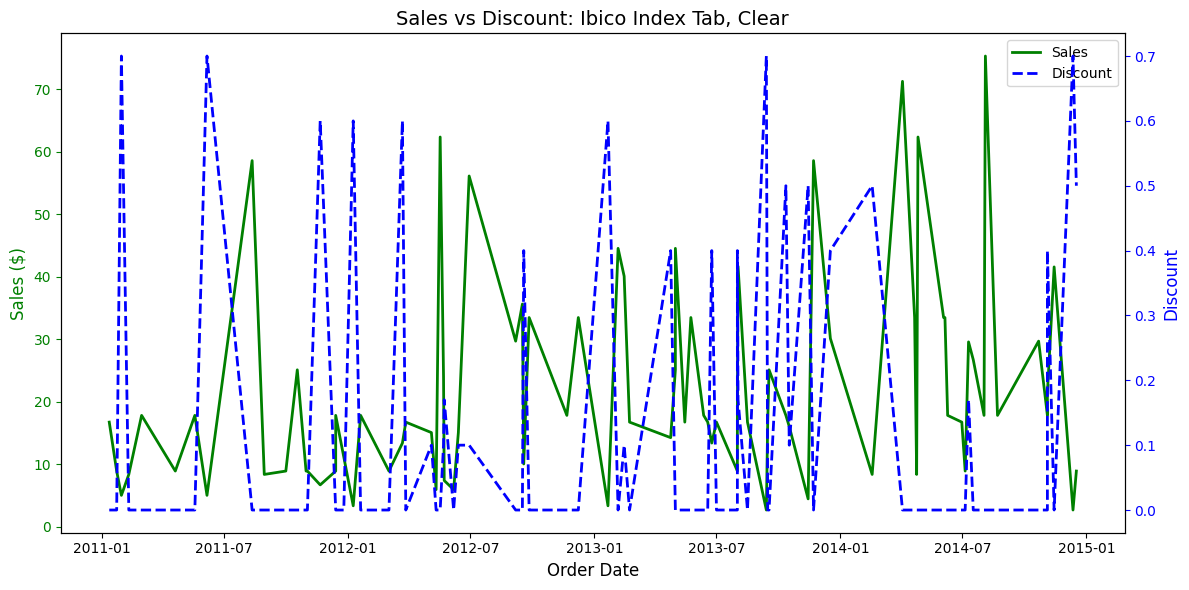

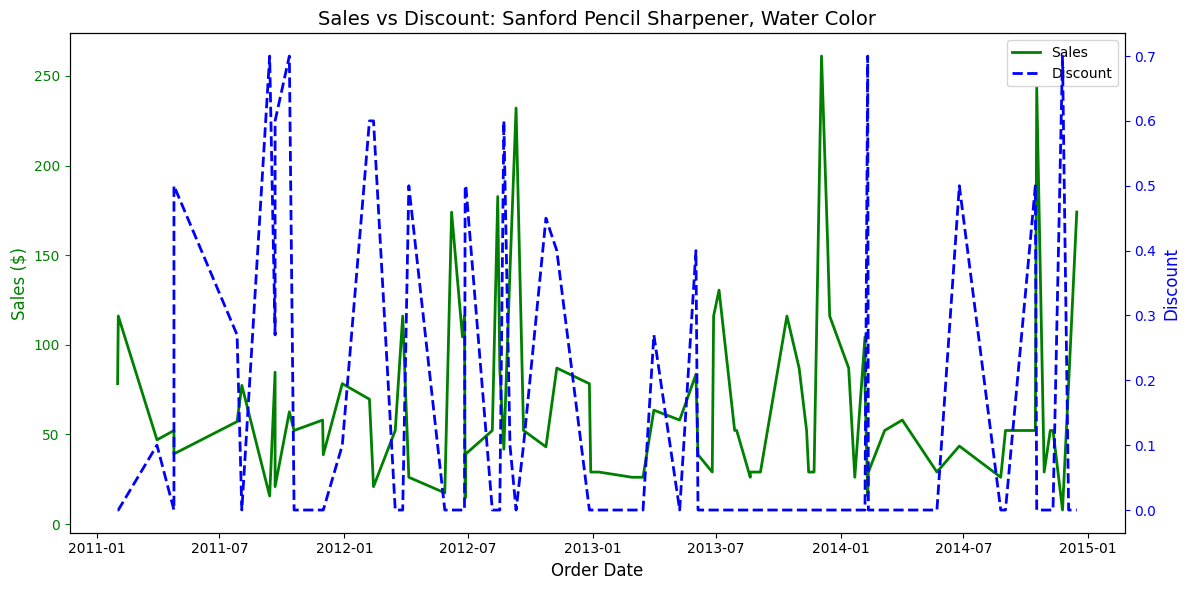

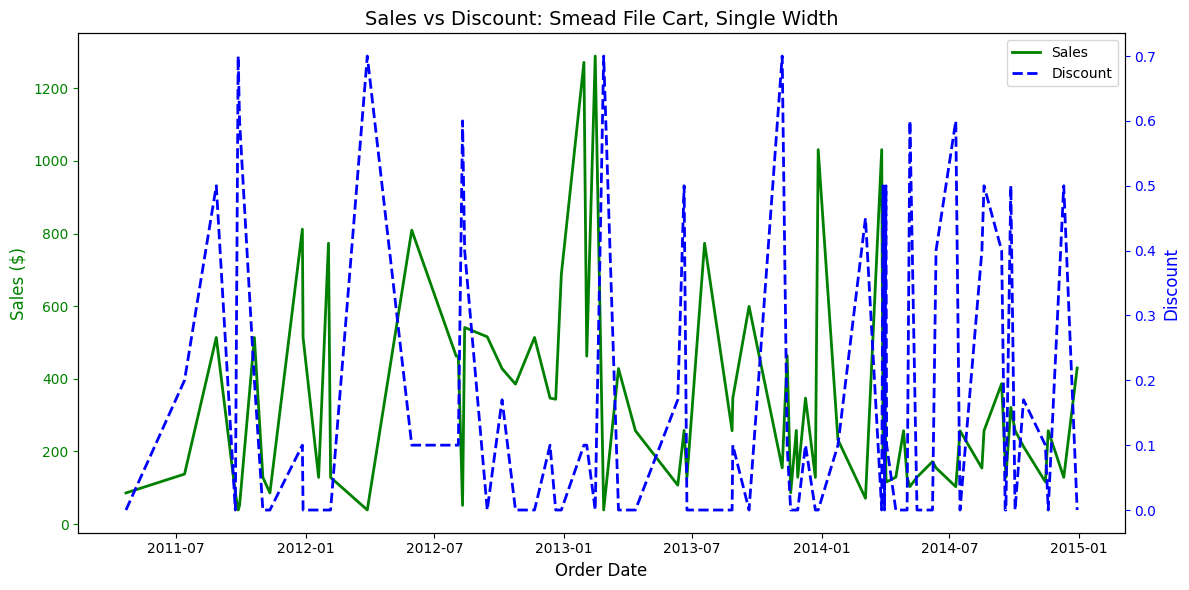

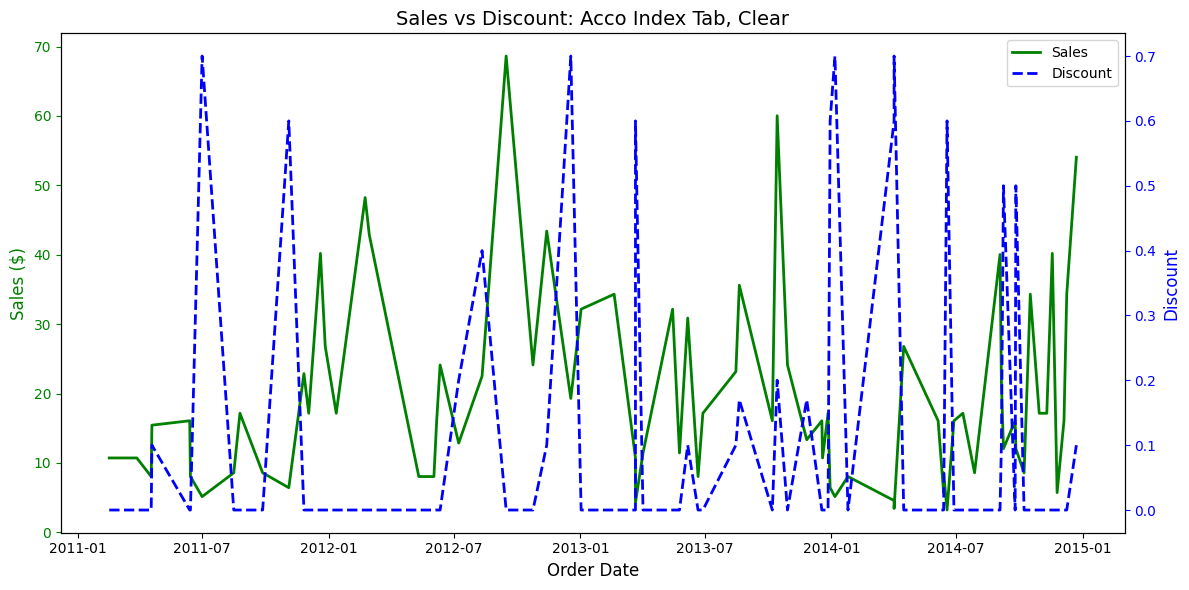

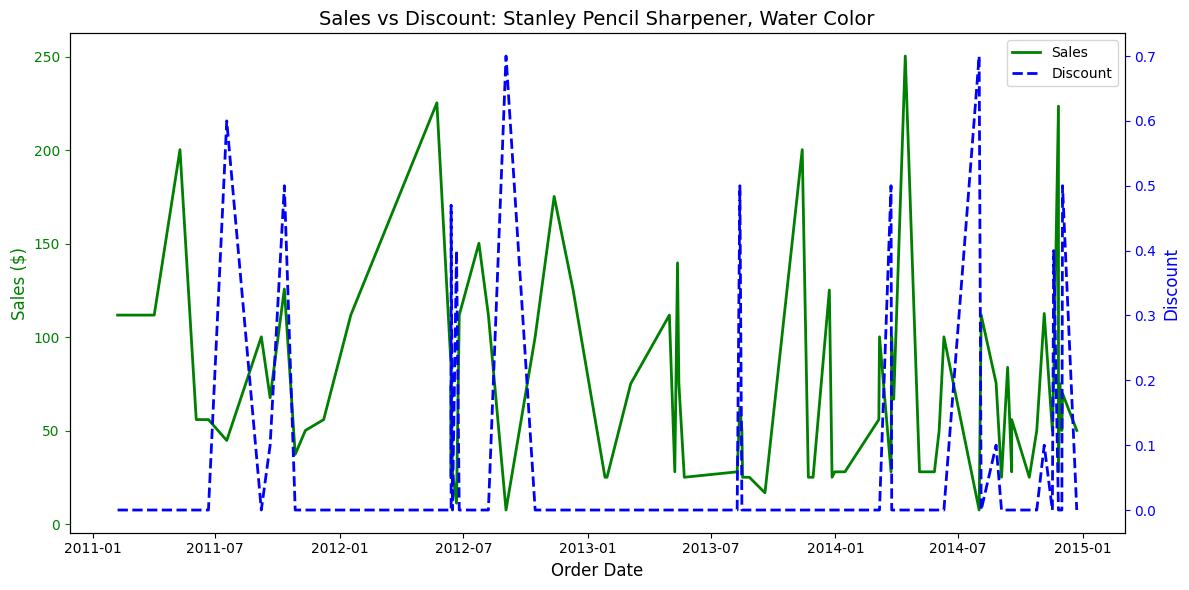

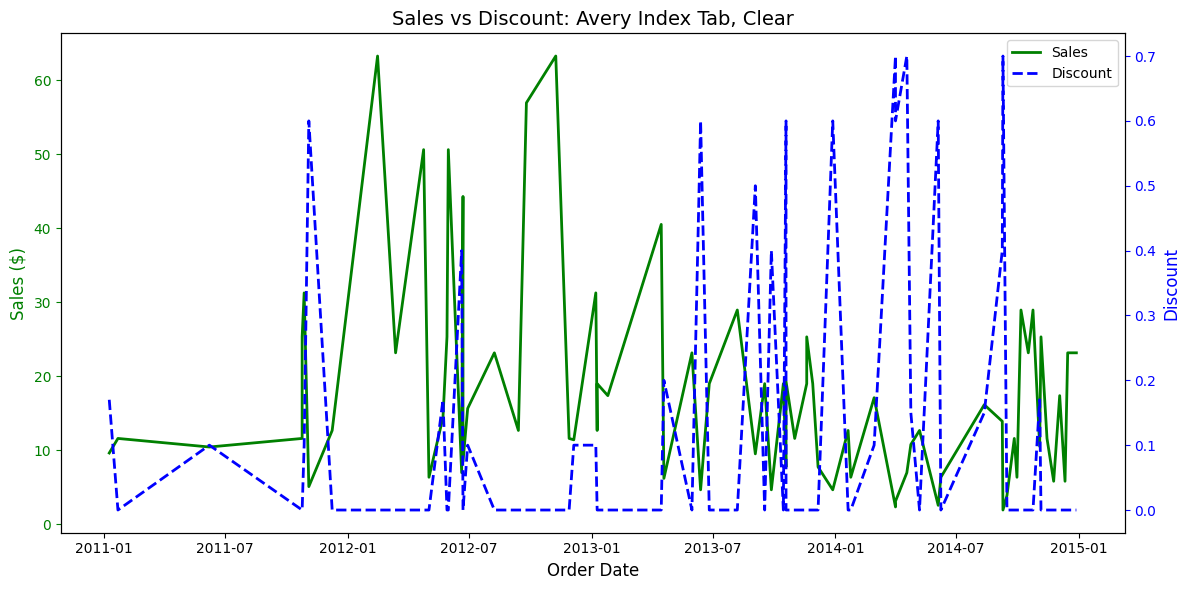

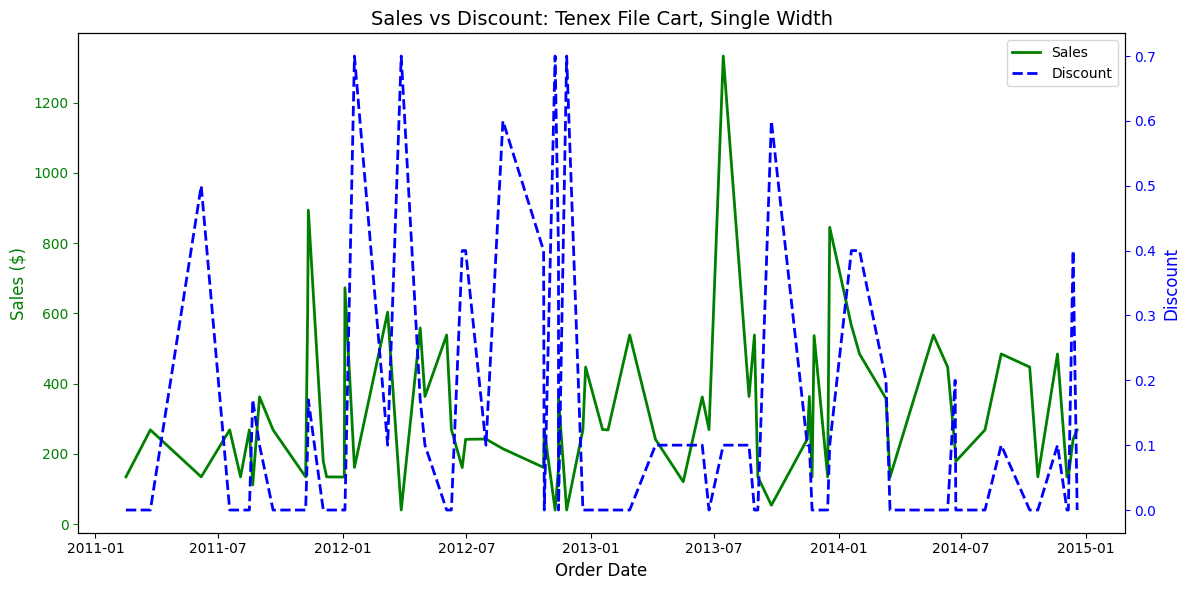

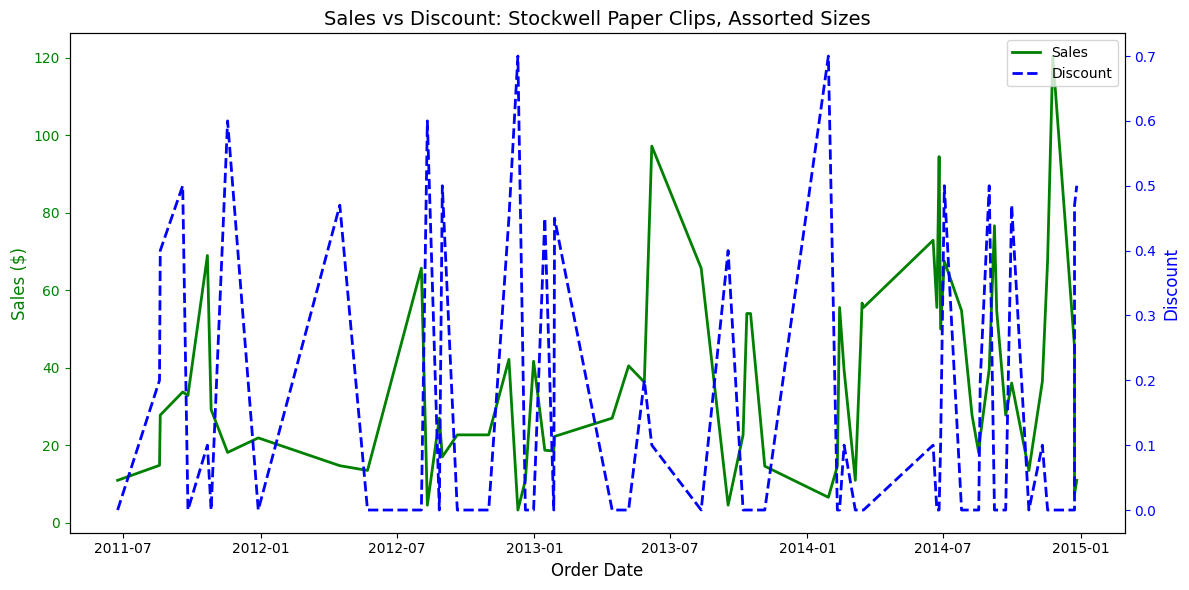

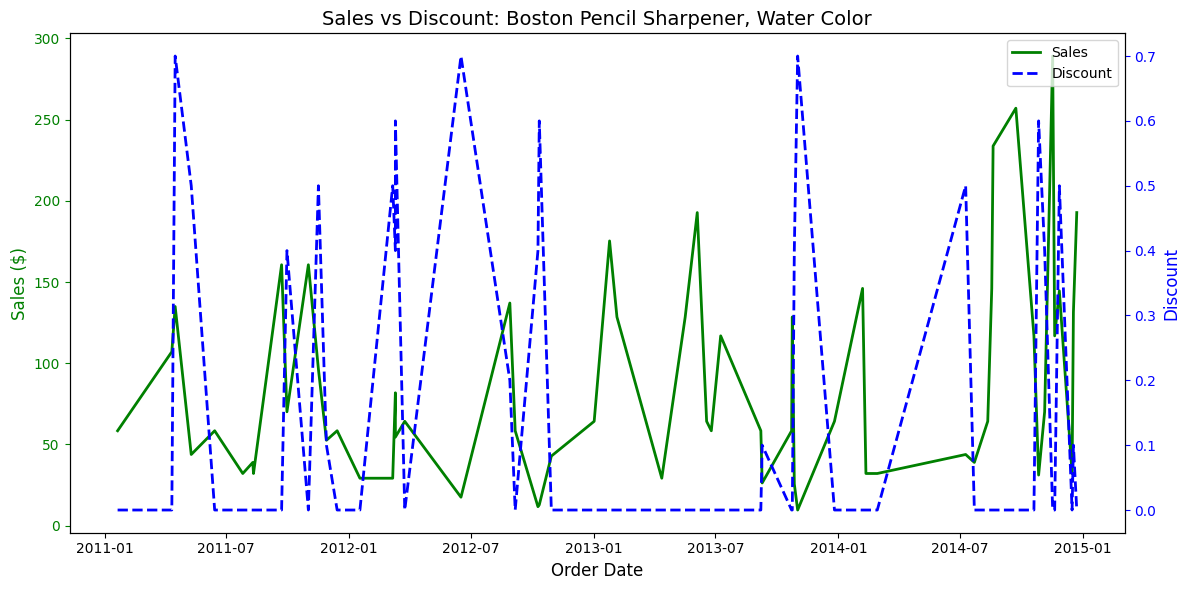

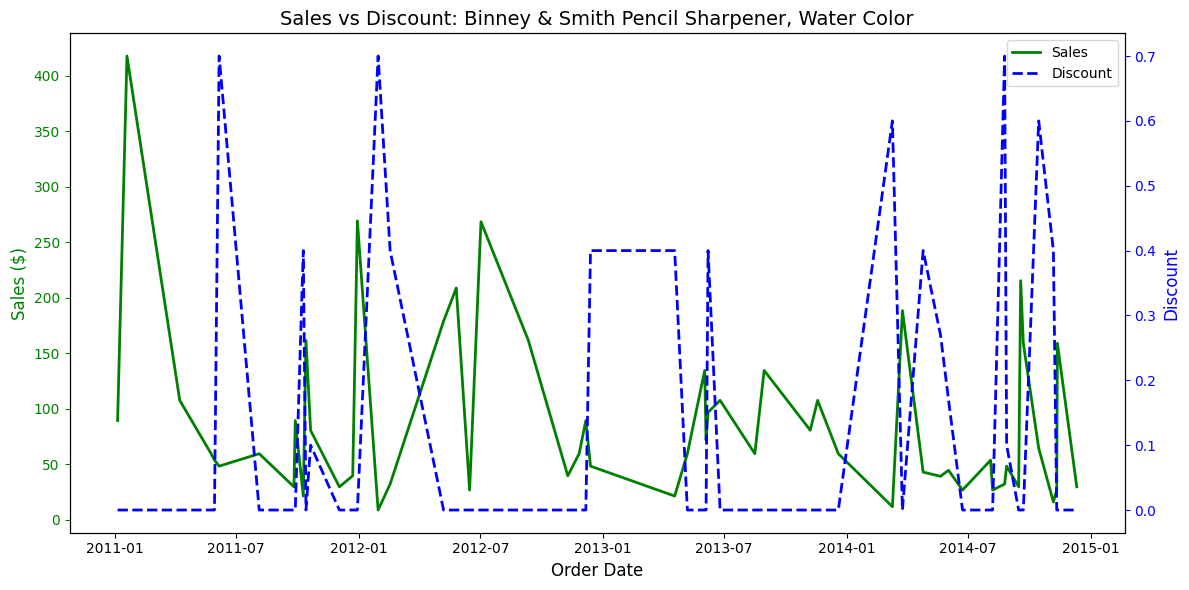

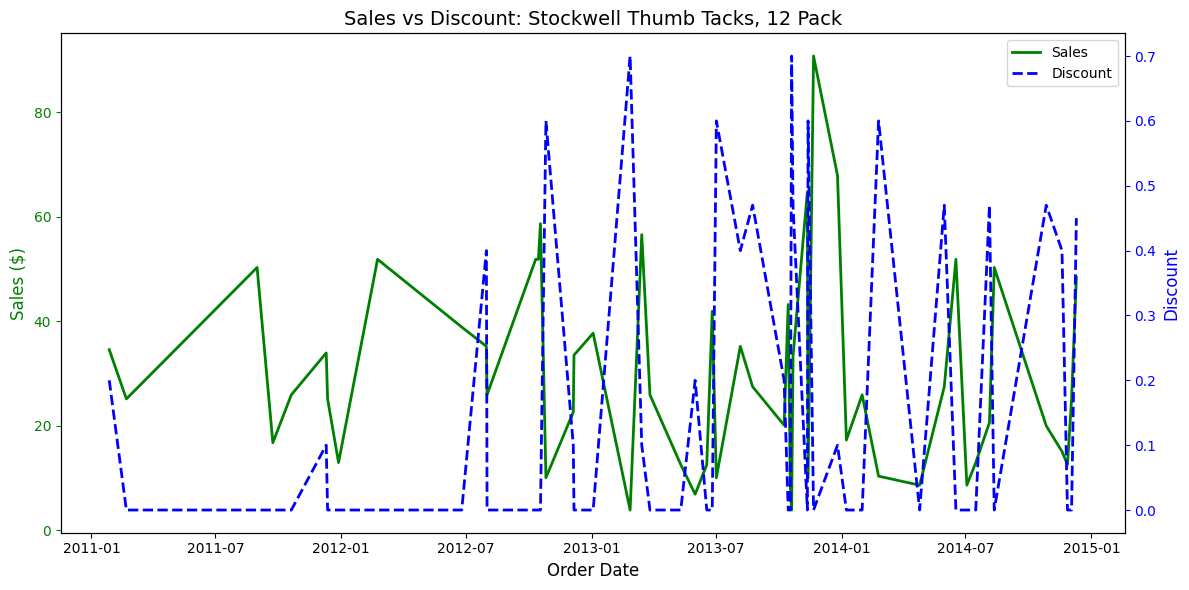

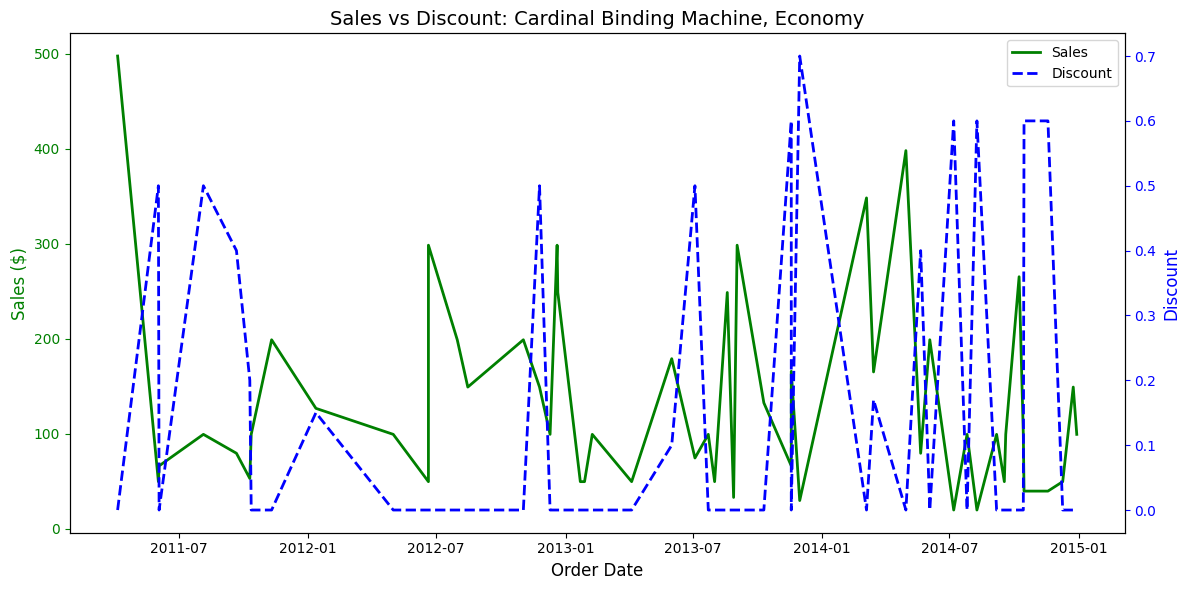

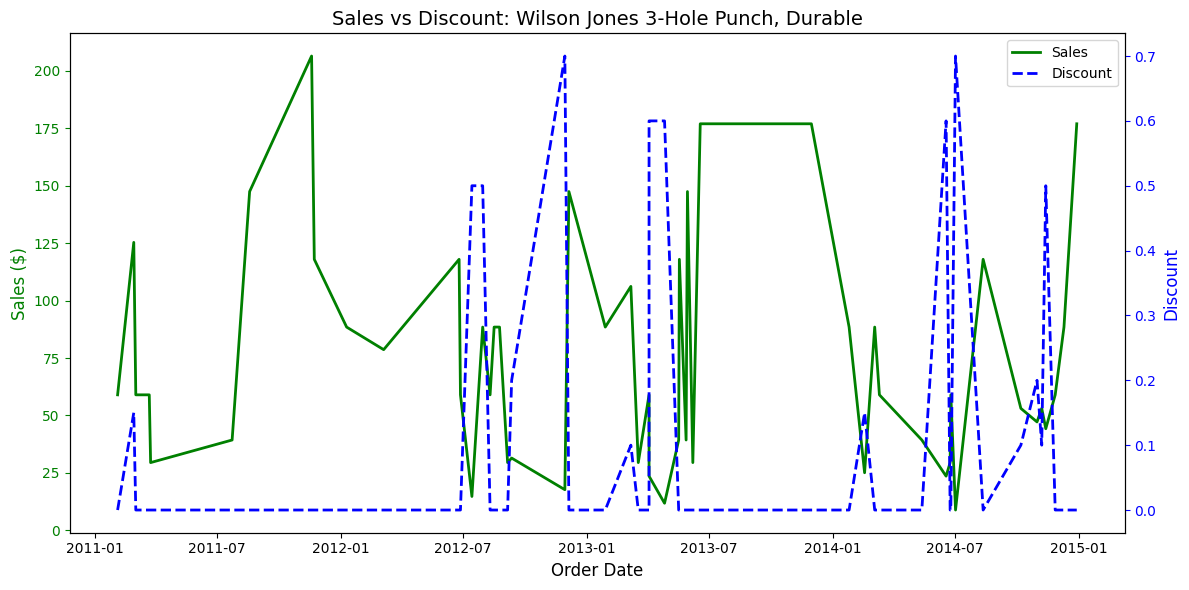

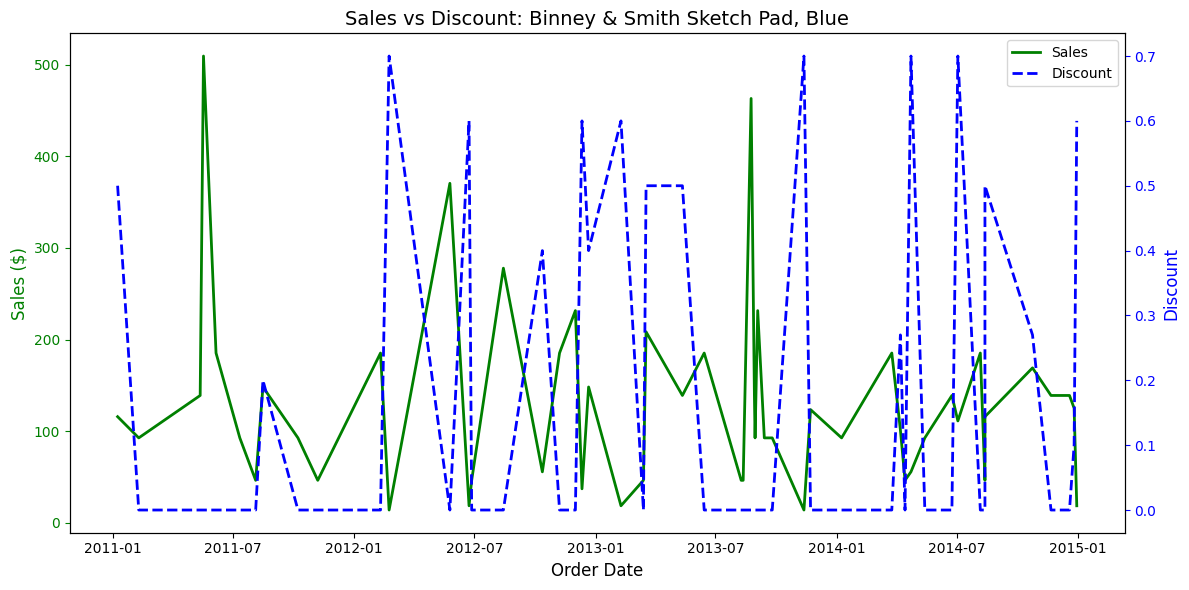

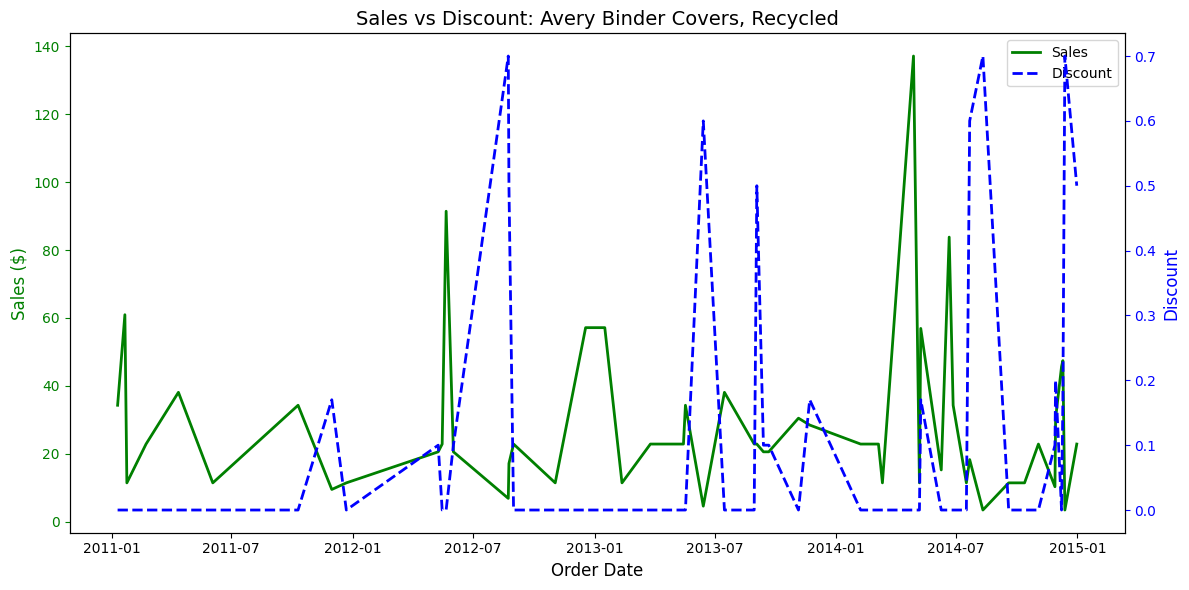

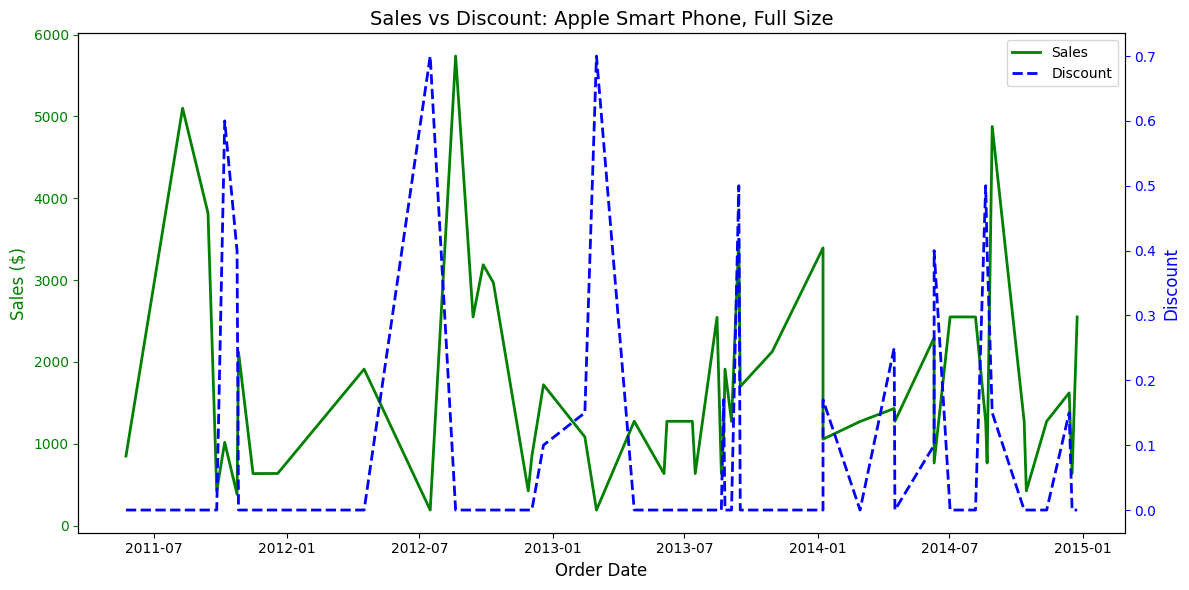

In [ ]:
# Using discount to determine price varying

sub_df = df[['Order Date', 'Product Name', '$Sales', 'Discount']]

# Count occurrences of each product
product_counts = sub_df['Product Name'].value_counts()
# print(product_counts)

# Filter products with count >= 50
products_over_50 = product_counts[product_counts > 50]
# print(products_over_50)

# Get the original DataFrame entries for these products
filtered_sub_df = sub_df[sub_df['Product Name'].isin(products_over_50.index)]
# filtered_sub_df

# get the list of products
list_filt_products = products_over_50.index.to_list()
list_filt_products

# Loop through each product and create a figure
for product in list_filt_products:
    # Filter data for the current product
    product_data = df[df['Product Name'] == product].sort_values('Order Date')
    
    # Skip if no data (safety check)
    if product_data.empty:
        continue
    
    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # Plot sales (left axis)
    ax1.plot(product_data['Order Date'], 
             product_data['$Sales'], 
             color='green', 
             linestyle='-', 
             linewidth=2,
             label='Sales')
    
    # Plot discounts (right axis)
    ax2.plot(product_data['Order Date'], 
             product_data['Discount'], 
             color='blue', 
             linestyle='--', 
             linewidth=2,
             label='Discount')
    
    # Formatting
    ax1.set_xlabel('Order Date', fontsize=12)
    ax1.set_ylabel('Sales ($)', color='green', fontsize=12)
    ax2.set_ylabel('Discount', color='blue', fontsize=12)
    ax1.tick_params(axis='y', colors='green')
    ax2.tick_params(axis='y', colors='blue')
    plt.title(f'Sales vs Discount: {product}', fontsize=14)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Save figure
    plt.tight_layout()
    plt.show()

> Analysis:
> - In order to indentify the trends, only Products that with more than 50 entries are selected
> - Some of them Sales are related to Discount while the others dont

2.4 What is the average delivery time across the counties - bar plot

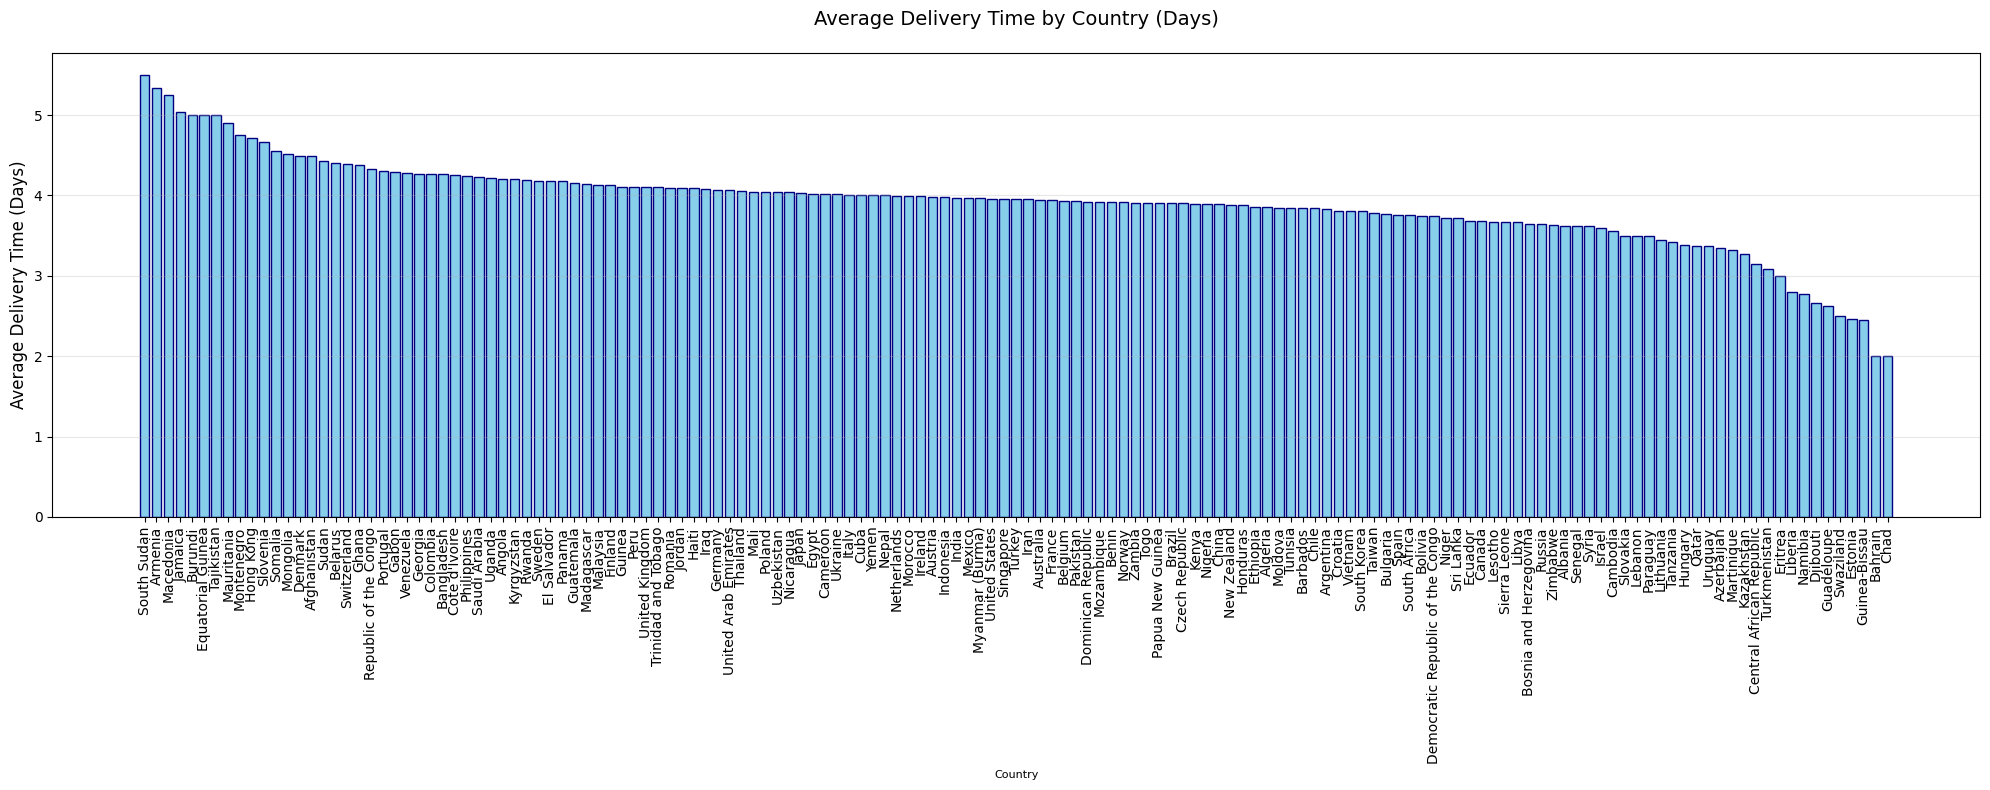

In [213]:
country_sub_df = df[['Order Date', 'Ship Date', 'Country']].copy()
country_sub_df['Delivery Time'] = country_sub_df['Ship Date'] - country_sub_df['Order Date']
country_sub_df.drop(columns=['Order Date', 'Ship Date'], inplace=True)
country_delivery = country_sub_df.groupby('Country')['Delivery Time'].mean().dt.total_seconds() / (3600*24) # find how many days
country_delivery = country_delivery.sort_values(ascending=False)
# print(country_delivery.values)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(
    x=country_delivery.index,
    height=country_delivery.values,
    color = 'skyblue',
    edgecolor = 'navy'
)
ax.set_title('Average Delivery Time by Country (Days)', fontsize=14, pad=20)
ax.set_xlabel('Country', fontsize=8)
ax.set_ylabel('Average Delivery Time (Days)', fontsize=12)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()